# Sparse Linear Solver Benchmark Visualization

This notebook loads and visualizes benchmark results comparing different sparse linear solvers on SPD systems.

## Methods Compared:
- **Dense**: Direct LU solver on dense matrix
- **Sparse**: Direct solver on sparse matrix (SuperLU)
- **CG**: Conjugate Gradient (unpreconditioned)
- **Jacobi**: Jacobi-preconditioned CG
- **IC**: Incomplete Cholesky preconditioned CG (optional)
- **AMG**: Algebraic Multigrid (optional)

（K + sigma^2 I）^-1

PMx = Pb

Differetiable?

'unrolled differentiation'


differentiate with conjugate gradient 

jax derivative 

pathwise conditioning

In [20]:
（K + sigma^2 I）^-1

PMx = Pb

Differetiable?



SyntaxError: invalid character '（' (U+FF08) (1429250375.py, line 1)

In [21]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 6)

def load_latest_results():
    """Load the most recent benchmark results."""
    folder = os.getcwd()
    pattern = os.path.join(folder, 'benchmark_sparse_*.csv')
    all_files = sorted(glob.glob(pattern))
    
    # Filter out summary files to get raw data
    raw_files = [f for f in all_files if 'summary' not in os.path.basename(f)]
    
    if not raw_files:
        raise FileNotFoundError("No benchmark results found. Run benchmark_sparse_solvers.py first.")
    
    latest_file = raw_files[-1]
    print(f"Loading: {os.path.basename(latest_file)}")
    
    return pd.read_csv(latest_file)

# Load data
df = load_latest_results()
print(f"Data shape: {df.shape}")
print(f"Methods: {sorted(df['method'].unique())}")
print(f"Problem sizes: {sorted(df['N'].unique())}")
df.head()

Loading: benchmark_sparse_20250714-125228.csv
Data shape: (250, 6)
Methods: ['amg', 'cg', 'dense', 'jacobi', 'spsolve']
Problem sizes: [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]


,N,seed,method,time,residual_norm,niter
0,16,0,dense,0.001342,2.695678e-15,NaN
1,16,0,spsolve,0.002617,2.415194e-15,NaN
2,16,0,cg,0.000281,1.252806e-07,17.0
3,16,0,jacobi,0.000191,1.144134e-07,17.0
4,16,0,amg,0.013824,2.008121e-02,100.0


## Performance Comparison

### 1. Solve Time vs Problem Size

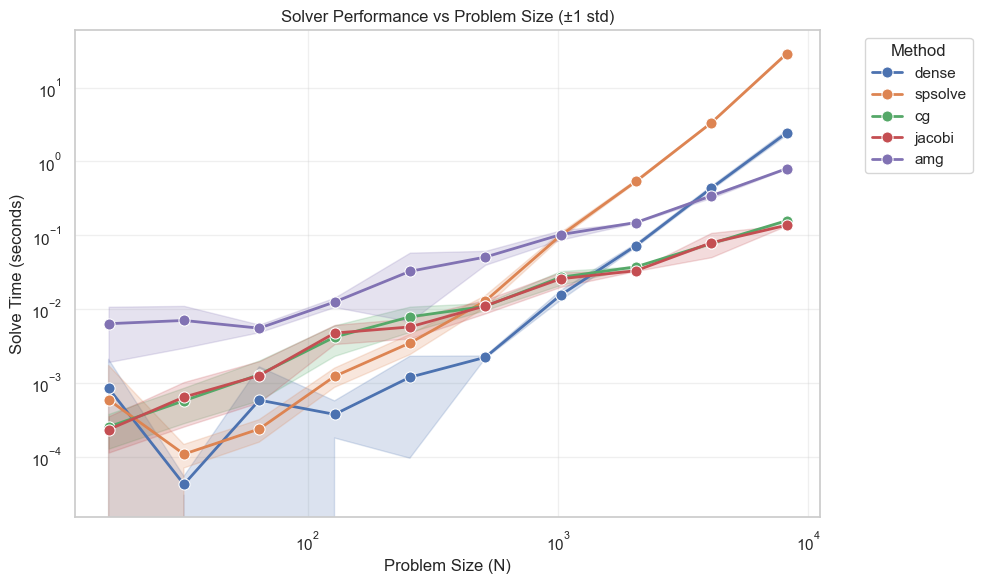

In [15]:
def plot_timing_comparison(df, figsize=(10, 6)):
    """Plot timing comparison with error bars."""
    plt.figure(figsize=figsize)
    
    sns.lineplot(
        data=df, 
        x='N', y='time',
        hue='method', 
        marker='o', 
        errorbar='sd',
        markersize=8,
        linewidth=2
    )
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Problem Size (N)')
    plt.ylabel('Solve Time (seconds)')
    plt.title('Solver Performance vs Problem Size (±1 std)')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_timing_comparison(df)

In [16]:
def create_interactive_plot(df):
    """Create interactive plot with error areas."""
    # Compute statistics
    stats = df.groupby(['N', 'method']).agg({
        'time': ['mean', 'std']
    }).reset_index()
    stats.columns = ['N', 'method', 'time_mean', 'time_std']
    
    # Create figure
    fig = go.Figure()
    methods = stats['method'].unique()
    colors = px.colors.qualitative.Plotly
    
    # Add traces for each method
    for i, method in enumerate(methods):
        method_data = stats[stats['method'] == method]
        color = colors[i % len(colors)]
        
        # Calculate bounds
        upper = method_data['time_mean'] + method_data['time_std']
        lower = method_data['time_mean'] - method_data['time_std']
        
        # Shaded error area
        fig.add_trace(go.Scatter(
            x=method_data['N'].tolist() + method_data['N'].tolist()[::-1],
            y=upper.tolist() + lower.tolist()[::-1],
            fill='toself',
            fillcolor=color,
            opacity=0.2,
            line=dict(width=0),
            showlegend=False,
            name=f'{method}_fill'
        ))
        
        # Main line
        fig.add_trace(go.Scatter(
            x=method_data['N'],
            y=method_data['time_mean'],
            mode='lines+markers',
            name=method,
            line=dict(color=color, width=3),
            marker=dict(size=8)
        ))
    
    # Create dropdown menu
    buttons = [
        dict(
            label="All Methods",
            method="update",
            args=[{"visible": [True] * len(fig.data)}]
        )
    ]
    
    # Individual method buttons
    for i, method in enumerate(methods):
        visibility = [False] * len(fig.data)
        visibility[i*2] = True      # fill
        visibility[i*2 + 1] = True  # line
        
        buttons.append(dict(
            label=method,
            method="update",
            args=[{"visible": visibility}]
        ))
    
    # Update layout
    fig.update_layout(
        title='Interactive Solver Performance (±1 std)',
        xaxis_title='Problem Size (N)',
        yaxis_title='Solve Time (seconds)',
        xaxis_type='log',
        yaxis_type='log',
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            direction="down",
            showactive=True,
            x=1.02,
            xanchor="left",
            y=1.0,
            yanchor="top"
        )],
        width=900,
        height=600
    )
    
    return fig

# Create and display interactive plot
fig = create_interactive_plot(df)
fig.show()

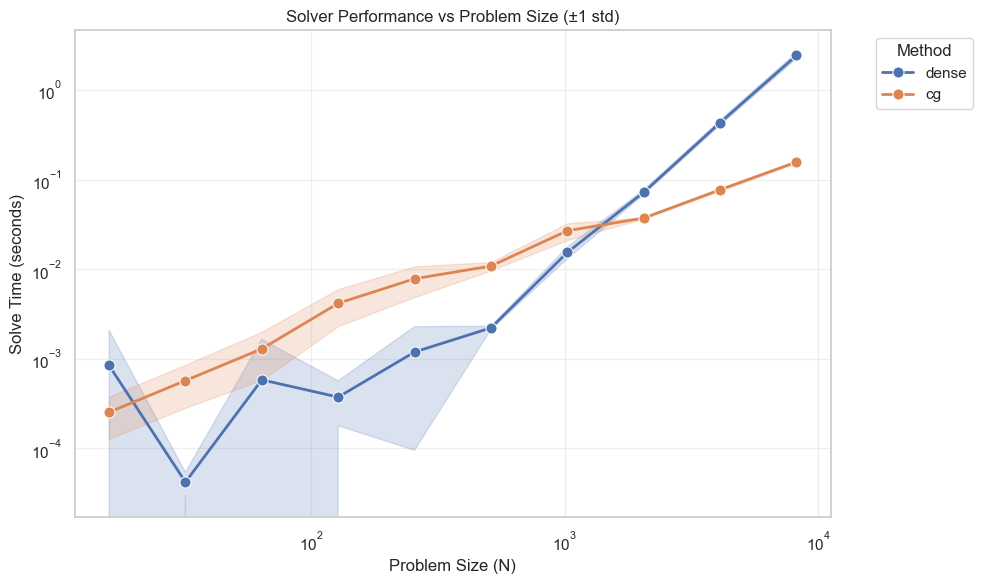

In [22]:
# Filter data for only dense and cg methods
filtered_df = df[df['method'].isin(['dense', 'cg'])]

# Create the timing plot with only dense and cg methods
plot_timing_comparison(filtered_df)

### 2. Solution Accuracy

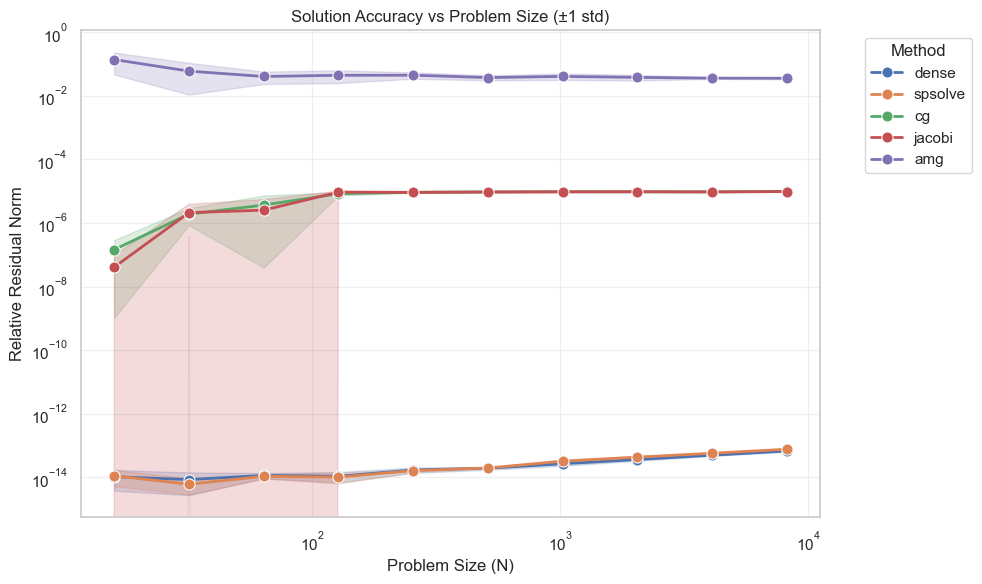

In [17]:
def plot_accuracy_comparison(df, figsize=(10, 6)):
    """Plot residual norm comparison."""
    plt.figure(figsize=figsize)
    
    sns.lineplot(
        data=df, 
        x='N', y='residual_norm',
        hue='method', 
        marker='o', 
        errorbar='sd',
        markersize=8,
        linewidth=2
    )
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Problem Size (N)')
    plt.ylabel('Relative Residual Norm')
    plt.title('Solution Accuracy vs Problem Size (±1 std)')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_accuracy_comparison(df)

### 3. Iteration Count Analysis

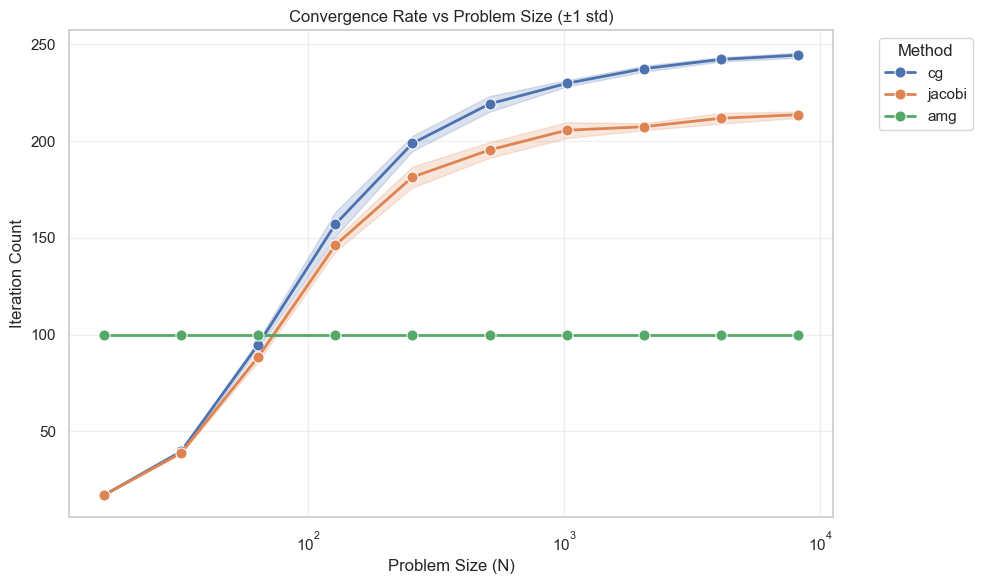

In [18]:
def plot_iteration_analysis(df, figsize=(10, 6)):
    """Plot iteration count for iterative methods."""
    # Filter iterative methods only
    iterative_df = df[df['niter'].notna()]
    
    if iterative_df.empty:
        print("No iterative methods found in data.")
        return
    
    plt.figure(figsize=figsize)
    
    sns.lineplot(
        data=iterative_df, 
        x='N', y='niter',
        hue='method', 
        marker='o', 
        errorbar='sd',
        markersize=8,
        linewidth=2
    )
    
    plt.xscale('log')
    plt.xlabel('Problem Size (N)')
    plt.ylabel('Iteration Count')
    plt.title('Convergence Rate vs Problem Size (±1 std)')
    plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_iteration_analysis(df)

### 4. Performance Summary

In [19]:
def print_performance_summary(df):
    """Print a summary of benchmark results."""
    print("=== PERFORMANCE SUMMARY ===\n")
    
    # Overall statistics
    summary = df.groupby('method').agg({
        'time': ['mean', 'std', 'min', 'max'],
        'residual_norm': ['mean', 'std'],
        'niter': ['mean', 'std']
    }).round(6)
    
    print("Time Statistics (seconds):")
    print(summary['time'])
    print("\nAccuracy Statistics (relative residual):")
    print(summary['residual_norm'])
    print("\nIteration Statistics:")
    print(summary['niter'])
    
    # Best performer by problem size
    print("\n=== FASTEST METHOD BY PROBLEM SIZE ===")
    fastest = df.groupby(['N', 'method'])['time'].mean().reset_index()
    fastest_per_size = fastest.loc[fastest.groupby('N')['time'].idxmin()]
    
    for _, row in fastest_per_size.iterrows():
        print(f"N={row['N']:>6}: {row['method']:<10} ({row['time']:.6f}s)")

print_performance_summary(df)

=== PERFORMANCE SUMMARY ===

Time Statistics (seconds):
             mean       std       min        max
method                                          
amg      0.150593  0.240317  0.003527   0.802125
cg       0.032459  0.048164  0.000164   0.162397
dense    0.296739  0.735220  0.000019   2.766431
jacobi   0.029821  0.043644  0.000171   0.138610
spsolve  3.280180  8.660152  0.000047  30.414234

Accuracy Statistics (relative residual):
             mean       std
method                     
amg      0.051680  0.043180
cg       0.000007  0.000004
dense    0.000000  0.000000
jacobi   0.000007  0.000004
spsolve  0.000000  0.000000

Iteration Statistics:
           mean        std
method                    
amg      100.00   0.000000
cg       168.02  83.533811
dense       NaN        NaN
jacobi   150.56  72.302979
spsolve     NaN        NaN

=== FASTEST METHOD BY PROBLEM SIZE ===
N=    16: jacobi     (0.000233s)
N=    32: dense      (0.000042s)
N=    64: spsolve    (0.000238s)
N=   128: de